In [ ]:
# https://www.youtube.com/watch?v=CSpsB4_-5WQ
# https://github.com/dredwardhyde/Seq2Seq-Chatbot-English/blob/master/chatbot_big.py

# Sequence2Sequence - Mô hình LSTM

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from underthesea import word_tokenize 

from keras import Input, Model
from keras.layers import Embedding, LSTM, Dense
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

import warnings
warnings.filterwarnings("ignore")

: 

# Tiền xử lý dữ liệu

In [ ]:
# load data
df = pd.read_csv('./chatbot-data.csv', usecols=[1,2])
df

,user_a,user_b
0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,Có crush ai không,Có 1 bạn cùng lớp
2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,Có hay nói chuyện không,Hay nhắn tin messenger
4,Bạn kia có bắt chuyện trước không,Có đôi khi
...,...,...
7389,Uầy vậy anh em mình có nên đi thể dục thể thao...,Vậy mày định rủ tao đi tập gì.
7390,Tao thấy bộ môn đó khá được ưa chuộng và còn n...,Mày xem các dân tổ đua xe nhiều quá nên ảo rồi...
7391,Đùa tí thôi tao tính rủ mày đi học võ bro.,Được nè. Tao khá thích taekwondo nhe.
7392,Tao sẽ học lên đai đen để về sút vào mấy thằng...,Oke mày là nhất :))


In [ ]:
# lấy ra Questions và Answers
data_questions = df['user_a'].values
data_answers = df['user_b'].values

In [ ]:
# hàm để xóa các ký tự đặc biệt
def clean_text(sent):
    return re.sub(r'[!“”"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', sent)

# hàm để chuyển Word Segmentation cho tiếng Việt
def clean_and_word_segmentation(sent):
    return word_tokenize(clean_text(sent.lower()), format='text')

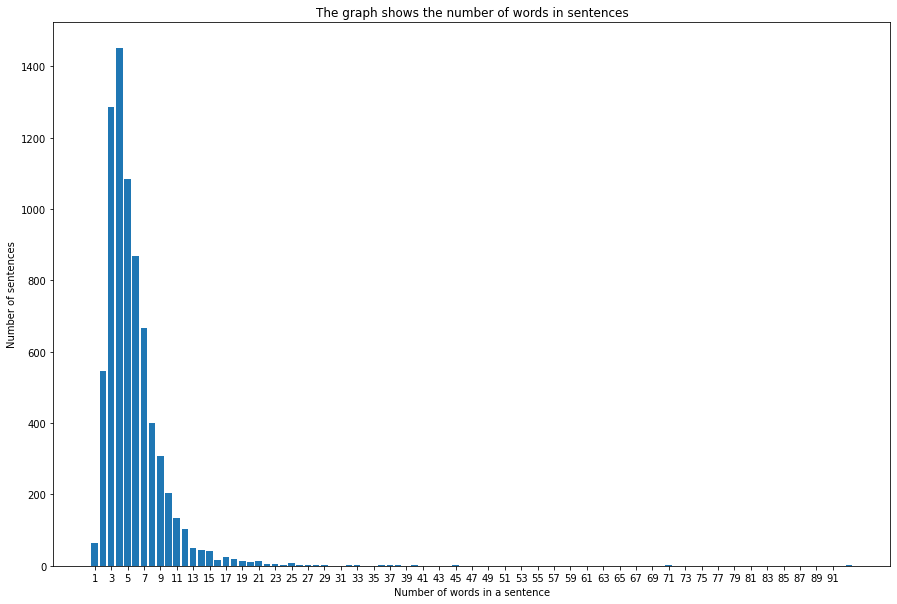

In [ ]:
# vẽ biểu đồ thể hiện trực quan số lượng từ trong các questions
count_words_ques = [len(clean_text(ques).split()) for ques in data_questions]
counter_words_ques = Counter(count_words_ques)

list_count_word = []
list_count_sent = []
for i in counter_words_ques.items():
    #print(i)
    list_count_word.append(i[0])
    list_count_sent.append(i[1])
    
# ========== draw ========== #
plt.figure(figsize=(15,10))
plt.bar(list_count_word,list_count_sent)
plt.title('The graph shows the number of words in sentences')
plt.xlabel('Number of words in a sentence')
plt.ylabel('Number of sentences')
plt.xticks(range(min(list_count_word), max(list_count_word),2))
plt.show()

In [ ]:
len(count_words_ques), len(data_questions)

(7394, 7394)

In [ ]:
# loại bỏ những câu có số lượng từ > 15 từ
sorted_ques = []
sorted_ans = []
for i,count in enumerate(count_words_ques):
    if count <= 15:
        sorted_ques.append(data_questions[i])
        sorted_ans.append(data_answers[i])
        
print('len sorted_ques:', len(sorted_ques))
print('len sorted_ans:', len(sorted_ans))
sorted_ques[:2], sorted_ans[:2]

len sorted_ques: 7256
len sorted_ans: 7256


(['Thích mẫu người nào', 'Có crush ai không'],
 ['Dễ thương, tóc dài, da trắng', 'Có 1 bạn cùng lớp'])

In [ ]:
# làm sạch và Word Segmentation cho sorted_ques và sorted_ans
questions = [clean_and_word_segmentation(ques) for ques in sorted_ques]
answers = ['<START> '+ clean_and_word_segmentation(answ) + ' <END>' for answ in sorted_ans]

questions[:2], answers[:2]

(['thích mẫu người nào', 'có crush ai không'],
 ['<START> dễ_thương tóc dài da trắng <END>',
  '<START> có 1 bạn cùng lớp <END>'])

In [ ]:
# tokenize cho questions và answers
tokenizer = Tokenizer(filters='', lower=False)  # filters='' do dữ liệu đã được làm sạch và giữ lại word segmention
tokenizer.fit_on_texts(questions + answers)

In [ ]:
# for word_index in tokenizer.word_index.items():
#     print(word_index)

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size : {VOCAB_SIZE}')

Vocabulary size : 4384


In [ ]:
np.shape(questions)

(7256,)

In [ ]:
# encoder
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = 15
encoder_inp = pad_sequences(tokenized_questions,maxlen=maxlen_questions,padding='post')

print(encoder_inp.shape)
print(questions[:5])
print(tokenized_questions[:5])
print(encoder_inp[:5])

(7256, 15)
['thích mẫu người nào', 'có crush ai không', 'tại_sao lại thích bạn dó', 'có hay nói_chuyện không', 'bạn kia có bắt_chuyện trước không']
[[12, 294, 35, 13], [4, 108, 47, 3], [337, 165, 12, 6, 1717], [4, 22, 804, 3], [6, 445, 4, 1382, 235, 3]]
[[  12  294   35   13    0    0    0    0    0    0    0    0    0    0
     0]
 [   4  108   47    3    0    0    0    0    0    0    0    0    0    0
     0]
 [ 337  165   12    6 1717    0    0    0    0    0    0    0    0    0
     0]
 [   4   22  804    3    0    0    0    0    0    0    0    0    0    0
     0]
 [   6  445    4 1382  235    3    0    0    0    0    0    0    0    0
     0]]


In [ ]:
# decoder
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = np.max([len(x) for x in tokenized_answers])
decoder_inp = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

print(decoder_inp.shape)
print(answers[0])
print(tokenized_answers[0])
print(decoder_inp[0])

(7256, 43)
<START> dễ_thương tóc dài da trắng <END>
[1, 341, 1138, 454, 2112, 620, 2]
[   1  341 1138  454 2112  620    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [ ]:
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
    
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')
decoder_final_output = to_categorical(padded_answers, VOCAB_SIZE)

print(decoder_final_output.shape)
print(tokenized_answers[0])
print(padded_answers[0])
print(decoder_final_output.shape)

(7256, 43, 4384)
[341, 1138, 454, 2112, 620, 2]
[ 341 1138  454 2112  620    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
(7256, 43, 4384)


In [ ]:
VOCAB_SIZE

4384

In [ ]:
enc_inputs = Input(shape=(None,))
enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
_, state_h, state_c = LSTM(200, return_state=True)(enc_embedding)
enc_states = [state_h, state_c]

dec_inputs = Input(shape=(None,))
dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
dec_lstm = LSTM(200, return_state=True, return_sequences=True)

dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
dec_dense = Dense(VOCAB_SIZE, activation='softmax')
output = dec_dense(dec_outputs)

In [ ]:
model = Model([enc_inputs, dec_inputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    876800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    876800      ['input_2[0][0]']                
                                                                                              

In [ ]:
model.fit([encoder_inp, decoder_inp],
           decoder_final_output,
           batch_size=100,
           epochs=10)
model.save('sequence2sequence_lstm.h5')

Epoch 1/10
73/73 [==============================] - 98s 1s/step - loss: 0.6918
Epoch 2/10
73/73 [==============================] - 77s 1s/step - loss: 0.5898
Epoch 3/10
73/73 [==============================] - 90s 1s/step - loss: 0.5691
Epoch 4/10
73/73 [==============================] - 82s 1s/step - loss: 0.5548
Epoch 5/10
73/73 [==============================] - 76s 1s/step - loss: 0.5407
Epoch 6/10
73/73 [==============================] - 80s 1s/step - loss: 0.5269
Epoch 7/10
73/73 [==============================] - 84s 1s/step - loss: 0.5139
Epoch 8/10
73/73 [==============================] - 81s 1s/step - loss: 0.5019
Epoch 9/10
73/73 [==============================] - 86s 1s/step - loss: 0.4903
Epoch 10/10
73/73 [==============================] - 80s 1s/step - loss: 0.4792


In [ ]:
import pickle
pickle.dump(model, open('chatbot.sav','wb'))

In [ ]:
def make_inference_models():
    dec_state_input_h = Input(shape=(200,))
    dec_state_input_c = Input(shape=(200,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                            initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs = [dec_outputs] + dec_states)
    print('Inference decoder:')
    dec_model.summary()
    print('Inference encoder:')
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    enc_model.summary()
    return enc_model, dec_model

def str_to_tokens(sentence):
    #words = sentence.lower().split()
    words = clean_and_word_segmentation(sentence).split()
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word)
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list], maxlen=maxlen_questions,padding='post')

enc_model, dec_model = make_inference_models()

Inference decoder:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    876800      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                         

In [ ]:
def chatbot(input):
    print('Bot: Xin chào!')
    
    while True:
        input_question = input
    
        if input_question == '':
            print('Bot answer: bye')
            break
        states_values = enc_model.predict(str_to_tokens(input_question))
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = tokenizer.word_index['<START>']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition:
            dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values)
            sampled_word_index = np.argmax(dec_outputs[0,-1, :])
            sampled_word = None
            for word, index in tokenizer.word_index.items():
                if sampled_word_index == index:
                    if word != '<END>':
                        decoded_translation += f'{word} '
                    sampled_word = word

            if sampled_word == '<END>' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True
            empty_target_seq = np.zeros((1,1))
            empty_target_seq[0,0] = sampled_word_index
            states_values = [h,c]
        print('User: ',input_question)
        print('Bot answer:', decoded_translation, '\n')

In [ ]:
# chat with bot
chatbot()

Bot: Xin chào!
User:  tên gì
Bot answer: hùng  

User:  có học đại học không
Bot answer: có  

User:  có ở kí túc xá trường không?
Bot answer: có  

User:  trường ở đâu
Bot answer: quận 7  

User:  học mấy năm rồi?
Bot answer: 2 năm  

User:  cao nhiêu?
Bot answer: 1 m7  

Bot answer: bye


In [ ]:
enc_model.save("enc_model.h5")
dec_model.save("dec_model.h5")

In [ ]:
# enc_model = keras.models.load_model("./enc_model.h5")
# dec_model =  keras.models.load_model("./dec_model.h5")

In [ ]:
pickle.dump(tokenizer.word_index, open("tokenizer_word_index.sav", "wb"))

In [ ]:
pickle.dump(maxlen_answers, open("maxlen_answers.sav", "wb"))